## NYT Web Scraper 

### READ 
The underlying structure of how this scraper works is by using a bunch of lists. Each list should contain around 52 items, 
with each item being a state. Each list is a column in the dataframe. The scraper takes advantage of the dataframe structure to fill in 1 or 0's if that specific state meets varying hard-coded conditions. The final CSV contains each state, what has industries/businesses have reopened in that state, respective political party and governor, and COVID-19 data. The main purpose of this mini-project is to understand re-opening policies, find patterns, and conduct risk assessments on existing financial customers.   

In [94]:
import requests
import re 
from bs4 import BeautifulSoup 
import pandas as pd 
import numpy as np 
import datetime
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline 

# listofstates = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

#the URL we want to scrape. 
URL = "https://www.nytimes.com/interactive/2020/us/states-reopen-map-coronavirus.html"

# get the URL 
page = requests.get(URL) 

#turn the response into a beautiful soup object 
soup = BeautifulSoup(page.content, 'html.parser')

#find all the g-inner box divs. That will contain all the content we want
mydivs = soup.findAll("div", {"class": "g-inner-box"})

# create empty lists to fill, later we will fill in the dataframe we want
statelist = [] 
reopenedplaceslist = [] 
orderexpirationlist = []
reopenedboollist = [] 
industrylist = []

# loop through the soup that contains all the g-inner-box tags 
for div in mydivs: 
    
    #get the list of all states. use re-gex to make it so it matches the following format "State: Anything"
    state = div.find("div", {"data-state" : re.compile(r".*")})['data-state']
    statelist.append(state)
    
    #create a 'reopenedbool' to see if a state has reopened or not  
    try: 
        reopenedbool = div.find("div", {"class": 'g-details-subhed'}).text
    except: 
        reopenedbool = 'Not Reopened'
    
    # the boolean variable acts as a check to see whether or not to append "No Industry" to the list  
    boolean = False 
    divlist = div.find_all("div", {"class": "g-cat-name"})
    if(len(divlist)!= 0): 
        tempcount = 0
        for i in range(len(divlist)): 
            if(i == (len(divlist)-1) and boolean == False):
                industrylist.append("No Industry")
            elif (divlist[i].text == "Industries" and tempcount == 0):
                tempcount +=1 
                boolean = True 
                industrylist.append(divlist[i].find_next_sibling("div").text)
    else: 
        industrylist.append("No Industry")

    reopenedboollist.append(reopenedbool)
    
    #grab list of reopened places 
    reopenedplaces = div.find_all("div", {"class": 'g-cat-name'})

    #loop through list, change all items in reopenedplaces to text and append them to the reopenedplaceslist 
    for i in range(len(reopenedplaces)):
        reopenedplaces[i] = reopenedplaces[i].text
    reopenedplaceslist.append(reopenedplaces)

    #cleans it up to just show the date. 
    orderexpiration = div.find("span", {"class": 'g-date-details-text'}).text
    if (orderexpiration.split()[0] == "expired"): 
        orderexpiration = orderexpiration.split()[2] + " " + orderexpiration.split()[3]
        orderexpiration = orderexpiration.replace(".", "")
    
    #edge case with words 'struck' and 'in' in the expiration date sentence. 
    elif(orderexpiration.split()[0] == "struck" or orderexpiration.split()[0] == "in"): 
        orderexpiration = orderexpiration.split()[3] + " " + orderexpiration.split()[4]
        orderexpiration = orderexpiration.replace(".", "")
    
    #append the data to the order expiration list 
    orderexpirationlist.append(orderexpiration)
        

#create the dataframe 
df = pd.DataFrame() 

#Create all the columns necessary and initialize them to either a list or 0 if it is a condition column 
#Note: order matters. if you want to add columns, add it to the end of this long list
df['State'] = statelist
df['Reopened'] = reopenedbool
df['Reopened Places Overview'] = reopenedplaceslist
df['Order Expiration'] = orderexpirationlist    
df['Outdoor and recreation'] = 0 
df['Retail'] = 0
df['Food and drink'] = 0  
df['Personal care'] = 0 
df['Entertainment'] = 0 
df['Industries'] = 0 
df['Houses of worship'] = 0 
df["Total Count"] = 0  
df['Industries_List'] = industrylist
df["Manufacturing"] = 0 
df["Warehouses"] = 0 
df["Offices"] = 0 
df["Movie, TV and music production"] = 0
df["Distribution"] = 0
df["Construction"] = 0
df["Malls"] = 0
df["Hotels"] = 0



# First grab the "Industries List" which is a list. Use python 'in' functionality to do a search for the keyword 
# iterate through the dataframe. Set each column to 1 if one of the several hard-coded Industries exists
# Note: purposefully use if statements instead of if, else if structure so that you can run through all conditions

for index, row in df.iterrows():
    templist = row["Industries_List"]
    templist = templist.lower()
    if "manufacturing" in templist:  
        df.iloc[index, df.columns.get_loc("Manufacturing")] = 1 
    if "warehouses" in templist: 
        df.iloc[index, df.columns.get_loc("Warehouses")] = 1 
    if "offices" in templist: 
        df.iloc[index, df.columns.get_loc("Offices")] = 1 
    if "movie, tv and music production" in templist or "film" in templist: 
        df.iloc[index, df.columns.get_loc("Movie, TV and music production")] = 1 
    if "distribution" in templist: 
        df.iloc[index, df.columns.get_loc("Distribution")] = 1
    if "construction" in templist: 
        df.iloc[index, df.columns.get_loc("Construction")] = 1 
    if "malls" in templist: 
        df.iloc[index, df.columns.get_loc("Malls")] = 1 
    if "hotels" in templist: 
        df.iloc[index, df.columns.get_loc("Hotels")] = 1 
        

## PLEASE NOTE: MARYLAND IS A SPECIAL CASE TO WATCH FOR 
# do not have as granular as wanted. reopening soon is not its own section
# iterate through the dataframe. Set each column to 1 if one of the several hard-coded Reopened-Places exists
for index, row in df.iterrows():
    templist = row["Reopened Places Overview"]
    if "Outdoor and recreation" in templist: 
        df.iloc[index, df.columns.get_loc("Outdoor and recreation")] = 1 
    if "Retail" in templist: 
        df.iloc[index, df.columns.get_loc("Retail")] = 1 
    if "Food and drink" in templist: 
        df.iloc[index, df.columns.get_loc("Food and drink")] = 1 
    if "Personal care" in templist: 
        df.iloc[index, df.columns.get_loc("Personal care")] = 1 
    if "Entertainment" in templist: 
        df.iloc[index, df.columns.get_loc("Entertainment")] = 1
    if "Industries" in templist: 
        df.iloc[index, df.columns.get_loc("Industries")] = 1 
    if "Houses of worship" in templist: 
        df.iloc[index, df.columns.get_loc("Houses of worship")] = 1  

    
#adhoc indexing list. For all j's, loop through columns Order Expiration ... Industries
# We only need those columns to get the Total Count Column. 
# The 11th (j) column is the count column, which you are adding 1 to
indexinglist = [4,5,6,7,8,9]
for i in range(len(df.index)):
    for j in indexinglist: 
        if(df.iat[i,j] == 1): 
            df.iat[i,11] += 1
            

#get the current year, month, and day to help with naming the CSV output file
year = str(datetime.datetime.today().year) 
month = str(datetime.datetime.today().month) 
day = str(datetime.datetime.today().day) 



In [95]:
df

,State,Reopened,Reopened Places Overview,Order Expiration,Outdoor and recreation,Retail,Food and drink,Personal care,Entertainment,Industries,...,Total Count,Industries_List,Manufacturing,Warehouses,Offices,"Movie, TV and music production",Distribution,Construction,Malls,Hotels
0,Alabama,Reopened,"[Outdoor and recreation, Retail, Food and drin...",April 30,1,1,1,1,1,0,...,5,No Industry,0,0,0,0,0,0,0,0
1,Alaska,Reopened,"[Food and drink, Retail, Personal care, Outdoo...",April 24,1,1,1,1,1,0,...,5,No Industry,0,0,0,0,0,0,0,0
2,Arizona,Reopened,"[Retail, Personal care, Food and drink, Outdoo...",May 15,1,1,1,1,1,0,...,5,No Industry,0,0,0,0,0,0,0,0
3,Arkansas,Reopened,"[Outdoor and recreation, Personal care, Food a...",Did not have a statewide stay-at-home order.,1,0,1,1,1,0,...,4,No Industry,0,0,0,0,0,0,0,0
4,California,Reopened,"[Industries, Personal care, Food and drink, Ho...",March 19,1,1,1,1,1,1,...,6,"Manufacturing; Warehouses; Offices; Movie, TV ...",1,1,1,1,0,0,0,0
5,Colorado,Reopened,"[Personal care, Retail, Industries, Outdoor an...",April 26,1,1,1,1,1,1,...,6,Offices; Manufacturing,1,0,1,0,0,0,0,0
6,Connecticut,Reopened,"[Retail, Personal care, Entertainment, Industr...",May 20,1,1,1,1,1,1,...,6,Offices,0,0,1,0,0,0,0,0
7,Delaware,Reopened,"[Food and drink, Outdoor and recreation, Retai...",May 31,1,1,1,1,1,0,...,5,No Industry,0,0,0,0,0,0,0,0
8,District of Columbia,Reopened,"[Outdoor and recreation, Personal care, Entert...",May 29,1,1,1,1,1,0,...,5,No Industry,0,0,0,0,0,0,0,0
9,Florida,Reopened,"[Outdoor and recreation, Houses of worship, En...",May 4,1,1,1,1,1,0,...,5,No Industry,0,0,0,0,0,0,0,0


### Political Party/ Abbreviation Append

In [96]:
# Read in political party CSV, which contains the Governors by State 
pdata = pd.read_csv("politicalparty.csv", header = None) 
# Delete the Governor of Prefix of each sentence 
for i in range(len(pdata.index)):
    pdata.iat[i,0] = pdata.iat[i,0].replace("Governor of", "").strip() 

#create a new dataframe called left 
left = pd.DataFrame() 
# Merge existing regular df dataframe and left dataframe on state 
left = pd.merge(left=df, right=pdata, how='left', left_on='State', right_on=0)
#drop unnecessary columns 
left = left.drop(columns = [0,3])
# add in state abbreviations for ease in terms of graphing 
abbrevdata = pd.read_csv("abbrev.csv", header = None)
#rename merged columns to correct names  
left = left.rename(columns={1: 'Governor', 2: 'Party'})
#merge dataframes 
left = pd.merge(left=left, right=abbrevdata, how='left', left_on='State', right_on=0)
left = left.drop(columns = [0,1])
left = left.rename(columns={2: 'Abbreviation'})
# set dataframe to left dataframe 
df = left 
df

,State,Reopened,Reopened Places Overview,Order Expiration,Outdoor and recreation,Retail,Food and drink,Personal care,Entertainment,Industries,...,Warehouses,Offices,"Movie, TV and music production",Distribution,Construction,Malls,Hotels,Governor,Party,Abbreviation
0,Alabama,Reopened,"[Outdoor and recreation, Retail, Food and drin...",April 30,1,1,1,1,1,0,...,0,0,0,0,0,0,0,Kay Ivey,Republican,AL
1,Alaska,Reopened,"[Food and drink, Retail, Personal care, Outdoo...",April 24,1,1,1,1,1,0,...,0,0,0,0,0,0,0,Mike Dunleavy,Republican,AK
2,Arizona,Reopened,"[Retail, Personal care, Food and drink, Outdoo...",May 15,1,1,1,1,1,0,...,0,0,0,0,0,0,0,Doug Ducey,Republican,AZ
3,Arkansas,Reopened,"[Outdoor and recreation, Personal care, Food a...",Did not have a statewide stay-at-home order.,1,0,1,1,1,0,...,0,0,0,0,0,0,0,Asa Hutchinson,Republican,AR
4,California,Reopened,"[Industries, Personal care, Food and drink, Ho...",March 19,1,1,1,1,1,1,...,1,1,1,0,0,0,0,Gavin Newsom,Democratic,CA
5,Colorado,Reopened,"[Personal care, Retail, Industries, Outdoor an...",April 26,1,1,1,1,1,1,...,0,1,0,0,0,0,0,Jared Polis,Democratic,CO
6,Connecticut,Reopened,"[Retail, Personal care, Entertainment, Industr...",May 20,1,1,1,1,1,1,...,0,1,0,0,0,0,0,Ned Lamont,Democratic,CT
7,Delaware,Reopened,"[Food and drink, Outdoor and recreation, Retai...",May 31,1,1,1,1,1,0,...,0,0,0,0,0,0,0,John C. Carney Jr.,Democratic,DE
8,District of Columbia,Reopened,"[Outdoor and recreation, Personal care, Entert...",May 29,1,1,1,1,1,0,...,0,0,0,0,0,0,0,NaN,NaN,DC
9,Florida,Reopened,"[Outdoor and recreation, Houses of worship, En...",May 4,1,1,1,1,1,0,...,0,0,0,0,0,0,0,Ron DeSantis,Republican,FL


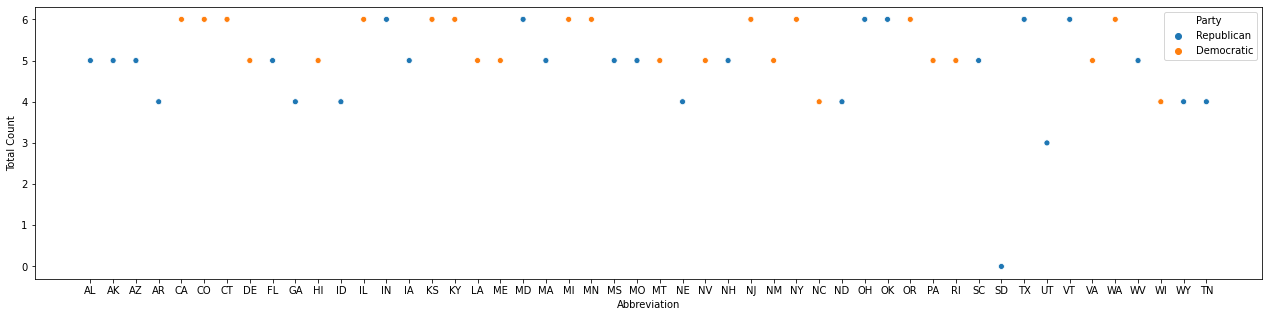

In [97]:
# set size of graph 
a4_dims = (22,5)
fig, ax = plt.subplots(figsize=a4_dims)
# scatter plot with abbreviation vs. total count 
sns.scatterplot(ax = ax, x="Abbreviation", y="Total Count", hue = "Party", data=df)
# save the graph as a viewable PDF 
plt.savefig('polpartyvstotalcount.pdf')

In [99]:
df.to_csv('SMB States Reopening NY Times Article ' + year + "." + month + "." + day + '.csv')


# Sandbox

In [85]:

#grab list of reopened places 
# testing = div.find_all("div", {"class": 'g-cat-name'})

# #change list of reopenedplaces to text 
# for i in range(len(reopenedplaces)):
# #     reopenedplaces[i] = reopenedplaces[i].text

testlist = []
for div in mydivs: 
    boolean = False 
    divlist = div.find_all("div", {"class": "g-cat-name"})
    if(len(divlist)!= 0): 
        tempcount = 0
        for i in range(len(divlist)):
            #check if there's another 'reopening soon' header on website. Only want to take the first 'industries' that we see in the div. 
            if (divlist[i].text == "Industries" and tempcount == 0):
                tempcount+=1 
                boolean = True 
                testlist.append(divlist[i].find_next_sibling("div").text)
            if(i == (len(divlist)-1) and boolean == False):
                testlist.append("No Industry")
    else: 
        testlist.append("No Industry")

52